In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
import sqlalchemy
import sqlite3
import os
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
os.getcwd()
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles'
os.chdir(new_path)

# Applying SQL to Movies

In this notebook I show you how I run and use **SQL** through special engines in **Python** to manage large databases & insightfully answer questions with additional analysis through libraries (Plotly, Seaborn, sk-learn). 

#### Why `SQL` with a  `Python` engine?

I will be running my queries using `Python` engines **SQLAlchemy** & **SQLite** in absence of a DMBS. 

I use a combination of the two engines in a **sandboxed workflow** because debugging is easier with `%sql` magic. After I've found the proper query, I like to copy it over to the `pd.read_sql` command for visualization, modeling, and export with Pandas, sklearn, and other Python libraries. This is a worklow I learned at UC Berkeley's Advanced Data Science Principles course, **Data 100**.

### The Data: IMDb Movie Database

To apply SQL, I will be using a subset of [IMDb's Movie Database](https://www.imdb.com). The year range is 1902-2021.



#### SQLite connection

In [3]:
conn = sqlite3.connect('imdbmini.db')

In [4]:
#load
%load_ext sql

In [5]:
%sql sqlite:///imdbmini.db

## SQLAlchemy connection

In [6]:
sqlite_conn = 'sqlite:///imdbmini.db'

In [7]:
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

## Preview of the Total IMDB Database 

In [8]:
%%sql 
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


There are 4 tables in this database: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click for Table Schema</b>] See descriptions of each table's data.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- averageRating (real) – weighted average of all the individual user ratings
- numVotes (integer) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- year (YYYY) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>

From the above descriptions, we can conclude:
* `Name.nconst` and `Title.tconst` are **primary keys** of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

### Previewing the Title table
What kind of information exists regarding movie titles in this database?

In [9]:
%%sql
SELECT * FROM Title
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


### What can we learn from the Titles dataset? 

**How far back does the data go for movies?**

In [10]:
%%sql
SELECT primaryTitle, startYear, titleType
FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
ORDER BY startYear
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


primaryTitle,startYear,titleType
The Birth of a Nation,1915,movie
The Cabinet of Dr. Caligari,1920,movie
The Kid,1921,movie
Nosferatu,1922,movie
Sherlock Jr.,1924,movie
Battleship Potemkin,1925,movie
The Gold Rush,1925,movie
The General,1926,movie
Metropolis,1927,movie
Sunrise,1927,movie


**What are the distribution of movies premiering each year?**

In [11]:
query_ydist = """
SELECT startYear, COUNT(*) AS total
FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
GROUP BY startYear;
"""

res_ydist = pd.read_sql(query_ydist, engine)
res_ydist

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


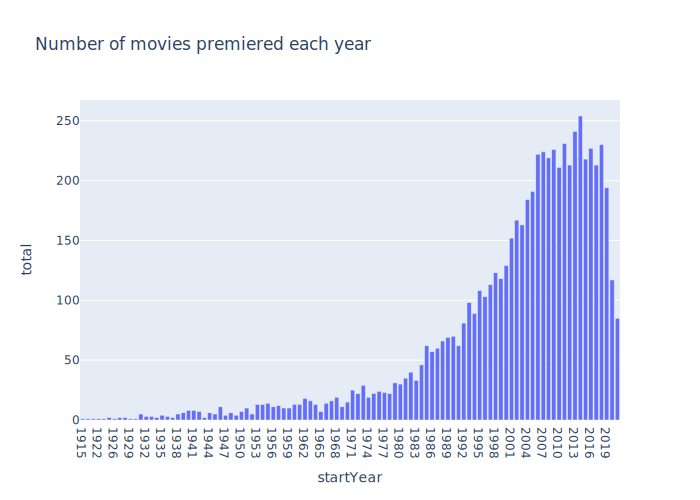

In [12]:
fig = px.bar(res_ydist, x="startYear", y="total", title="Number of movies premiered each year")
fig.show(renderer="svg")

**Who are the most prolific actors/actresses?**

In [13]:
%%sql
SELECT primaryName AS name, COUNT(*) AS total
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
WHERE (category = "actor" OR category = "actress") AND titleType = "movie"
GROUP BY primaryName
ORDER BY total DESC
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


name,total
Robert De Niro,64
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Morgan Freeman,40
Liam Neeson,40
Sylvester Stallone,39


**What are the top 10 highest rated movies?**

In [14]:
%%sql
SELECT primaryTitle AS title, 
    CAST(Rating.numVotes AS int) AS numVotes, 
    averageRating
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
ORDER BY numVotes DESC
LIMIT 10;

 * sqlite:///imdbmini.db
Done.


title,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


### What about Harry Potter Movies ? 
#### How many movies, when were they made, how long are they?

FYI: I do NOT consider "Fantastic Beasts" as belonging with Harry Potter...

In [15]:
%%sql
SELECT tconst AS id,
    titleType, 
    primaryTitle AS movieName, 
    startYear AS yearMade, 
    runtimeMinutes FROM Title
WHERE primaryTitle LIKE '%Harry%' AND primaryTitle LIKE '%Potter%';

 * sqlite:///imdbmini.db
Done.


id,titleType,movieName,yearMade,runtimeMinutes
241527,movie,Harry Potter and the Sorcerer's Stone,2001,152
295297,movie,Harry Potter and the Chamber of Secrets,2002,161
304141,movie,Harry Potter and the Prisoner of Azkaban,2004,142
330373,movie,Harry Potter and the Goblet of Fire,2005,157
373889,movie,Harry Potter and the Order of the Phoenix,2007,138
417741,movie,Harry Potter and the Half-Blood Prince,2009,153
926084,movie,Harry Potter and the Deathly Hallows: Part 1,2010,146
1201607,movie,Harry Potter and the Deathly Hallows: Part 2,2011,130


### Im going to deep-dive into my favorite genre:  Sci-Fi Drama 

### problem:
The genres column applies multiple genres to every movie. This makes it ***really hard*** to specify a unique singular genre type as every unique instance of a list of genres is "distinct". 

In [16]:
%%sql
SELECT DISTINCT genres
FROM Title
WHERE titleType = "movie"
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


genres
"Drama,History,War"
"Fantasy,Horror,Mystery"
"Comedy,Drama,Family"
"Fantasy,Horror"
"Action,Comedy,Romance"


In [17]:
%%sql genre_sql <<
SELECT * FROM Title;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable genre_sql


In [18]:
genre_df = genre_sql.DataFrame()

#pythonically
#genre_list = []
#genre_list = [word for sentence in genre_df["genres"].str.split(",") 
#                  for word in sentence 
#                      if word not in genre_list]
#genre_list

#iteratively
genres_list = []
type(genre_df["genres"][0])

for i in genre_df["genres"].str.split(","):
    for j in i:
        if j not in genres_list: 
            genres_list.append(j)

genres_list

['Action',
 'Adventure',
 'Comedy',
 'Drama',
 'History',
 'War',
 'Fantasy',
 'Horror',
 'Mystery',
 'Family',
 'Romance',
 'Thriller',
 'Sci-Fi',
 'Biography',
 'Documentary',
 'Music',
 'Short',
 'Crime',
 'Musical',
 'Animation',
 'Film-Noir',
 'Western',
 'Sport',
 'News',
 'Talk-Show',
 'Game-Show',
 'Reality-TV']

Now I have a list of genres names to work with.

### new problem: most movies are tagged as having multiple genres, skewing results of individual genres. It's better to work with multiple genres.

In [19]:
%%sql
SELECT genres, COUNT(*) AS count
FROM Title
WHERE genres NOT LIKE "%,%" AND titleType = "movie"
GROUP BY genres
ORDER BY count DESC;

 * sqlite:///imdbmini.db
Done.


genres,count
Drama,209
Comedy,181
Horror,52
Documentary,16
Thriller,7
Western,4
Action,3


Im going to now explore the data accounting for the fact that multiple genres are tagged.

#### What are the top-rated Sci-Drama movies of all time (within range)? 

In [20]:
%%sql 
SELECT T.tconst AS id,
  primaryTitle AS title, 
  titleType,
  genres,
  CAST(startYear AS int) AS year,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%DRAMA%"
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,title,titleType,genres,year,rating,numRatings
816692,Interstellar,movie,"Adventure,Drama,Sci-Fi",2014,8.6,1613897
482571,The Prestige,movie,"Drama,Mystery,Sci-Fi",2006,8.5,1244379
434409,V for Vendetta,movie,"Action,Drama,Sci-Fi",2005,8.1,1065965
338013,Eternal Sunshine of the Spotless Mind,movie,"Drama,Romance,Sci-Fi",2004,8.3,948018
3659388,The Martian,movie,"Adventure,Drama,Sci-Fi",2015,8.0,794444


### As of today (2024) the ratings have changed! 
Remember this dataset was collected from 2021, so I've accounted for that in this [IMDB](https://www.imdb.com/search/title/?title_type=feature&genres=sci-fi,drama&release_date=,2022-01-01&sort=num_votes,desc) search. But naturally, 3 years of additional ratings have shifted things.

It looks like "Avengers: Endgame" has gone up to 3rd place, shifting  "V for Vendetta", "Eternal Sunshine of the Spotless Mind" & "The Martian" down.

<center>
<img alt="top5scidrammoves" src="top5scidram.png" width="500px;" />
</center>

### Diving deeper into Sci-Fi Dramas

#### Im going to convert this into a Python dataframe so that I can explore it a bit more

In [21]:
%%sql sdram_movies_sql <<
SELECT T.tconst AS id,
  CAST(startYear AS int) AS year,
  primaryTitle AS title, 
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE year > 0     -- get rid of missing values --
      AND titleType = "movie"
      AND genres LIKE "%Sci-Fi%" AND genres LIKE "%Drama%"
ORDER BY numRatings DESC;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable sdram_movies_sql


In [22]:
sdram_df = sdram_movies_sql.DataFrame()
sdram_df.head()

,id,year,title,rating,numRatings
0,816692,2014,Interstellar,8.6,1613897
1,482571,2006,The Prestige,8.5,1244379
2,434409,2005,V for Vendetta,8.1,1065965
3,338013,2004,Eternal Sunshine of the Spotless Mind,8.3,948018
4,3659388,2015,The Martian,8.0,794444


### Average Ratings for Sci-Fi Drama movies across time

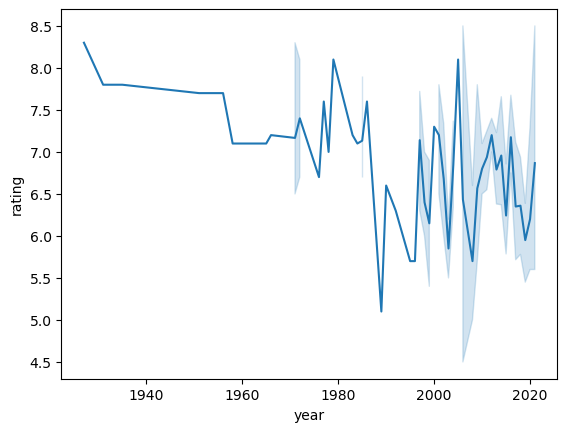

In [23]:
sns.lineplot(data=sdram_df, x="year", y="rating");

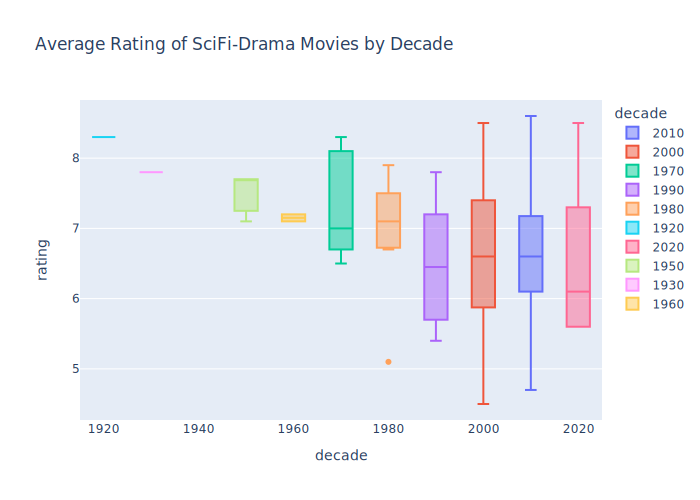

In [24]:
sdram_df['decade'] = (sdram_df['year'] // 10) * 10
fig = px.box(sdram_df, x = 'decade', y = 'rating', color = "decade", title=
      "Average Rating of SciFi-Drama Movies by Decade")

fig.show(renderer="svg")

### What can we find out about the first spike right before the 1980s?


Which **category** of **Sci-Fi movies** have the highest average ratings across all the movies in the 1970s-1980s? 

$$
\text{genreRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

In [25]:
%%sql

SELECT genres AS genre, SUM((averageRating)*numVotes)/SUM(numVotes) AS genreRating
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
INNER JOIN Rating ON Title.tconst = Rating.tconst
WHERE titleType = "movie"
    AND genre LIKE "%Sci-Fi%"
    AND CAST(numVotes AS int) > 1000
    AND (startYear <= 1980 AND startYear > 1969)
GROUP BY genre
HAVING COUNT(*) >= 20 
ORDER BY genreRating DESC
LIMIT 5; 


 * sqlite:///imdbmini.db
Done.


genre,genreRating
"Horror,Sci-Fi",8.240916267311826
"Drama,Mystery,Sci-Fi",7.839297346784274
"Drama,Sci-Fi",7.6407270571432395
"Action,Adventure,Sci-Fi",6.664460068612673
"Action,Sci-Fi",5.985656750035588


### It seems like the 70s preferred Horror / Drama Sci-Fi

In [26]:
%%sql 
SELECT T.tconst AS id,
    startYear AS year,
    primaryTitle AS title,
    genres,
    averageRating,
    numVotes
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE titleType = "movie"
      AND startYear <= 1980 AND startYear > 1969
      AND genres LIKE "%Sci-Fi%"     
ORDER BY averageRating DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,averageRating,numVotes
78748,1979,Alien,"Horror,Sci-Fi",8.4,822820
66921,1971,A Clockwork Orange,"Crime,Drama,Sci-Fi",8.3,785475
69293,1972,Solaris,"Drama,Mystery,Sci-Fi",8.1,86675
79944,1979,Stalker,"Drama,Sci-Fi",8.1,125999
70544,1973,Fantastic Planet,"Animation,Sci-Fi",7.8,28098


### It seems like the 80s preferred Adventure / Comedy Sci-Fi
#### What were they watching?



In [27]:
%%sql 
SELECT T.tconst AS id,
    startYear AS year,
    primaryTitle AS title,
    genres,
    averageRating,
    numVotes
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE titleType = "movie"
      AND startYear <= 1990 AND startYear > 1979
      AND genres LIKE "%Sci-Fi%"     
ORDER BY averageRating DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,averageRating,numVotes
88763,1985,Back to the Future,"Adventure,Comedy,Sci-Fi",8.5,1112320
90605,1986,Aliens,"Action,Adventure,Sci-Fi",8.3,678152
83658,1982,Blade Runner,"Action,Sci-Fi,Thriller",8.1,721364
84787,1982,The Thing,"Horror,Mystery,Sci-Fi",8.1,390752
88247,1984,The Terminator,"Action,Sci-Fi",8.0,820648


### How does this compare to other popular genres of the 80s ? 

In [28]:
%%sql 
SELECT genres AS genre, SUM((averageRating)*numVotes)/SUM(numVotes) AS genreRating
FROM Name
INNER JOIN Role ON Name.nconst = Role.nconst
INNER JOIN Title ON Title.tconst = Role.tconst
INNER JOIN Rating ON Title.tconst = Rating.tconst
WHERE titleType = "movie"
    AND CAST(numVotes AS int) > 1000
    AND (startYear <= 1990 AND startYear > 1979)
GROUP BY genre
HAVING COUNT(*) >= 20 
ORDER BY genreRating DESC
LIMIT 5; 

 * sqlite:///imdbmini.db
Done.


genre,genreRating
"Biography,Crime,Drama",8.647548818814863
"Drama,Horror",8.330405368695358
"Drama,War",8.158557477117057
"Adventure,Drama",8.100000000000001
"Action,Adventure,Fantasy",8.058857547263708


In [29]:
%%sql  
SELECT T.tconst AS id,
 CAST(startYear AS int) AS year,
  primaryTitle AS title,
  genres,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE (year <= 1990 AND year > 1979)
      AND titleType = "movie"
      AND genres LIKE "%Drama%" 
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,rating,numRatings
99685,1990,Goodfellas,"Biography,Crime,Drama",8.7,1069422
81505,1980,The Shining,"Drama,Horror",8.4,941780
86250,1983,Scarface,"Crime,Drama",8.3,777942
93058,1987,Full Metal Jacket,"Drama,War",8.3,701160
95953,1988,Rain Man,Drama,8.0,489908


In [30]:
#best movies of all time

In [31]:
%%sql  
SELECT T.tconst AS id,
 CAST(startYear AS int) AS year,
  primaryTitle AS title,
  genres,
  CAST(averageRating AS float) AS rating,
  CAST(numVotes AS int) AS numRatings  
FROM Title AS T INNER JOIN Rating AS R ON T.tconst = R.tconst
WHERE (year <= 1990 AND year > 1979)
      AND titleType = "movie"
ORDER BY numRatings DESC
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


id,year,title,genres,rating,numRatings
80684,1980,Star Wars: Episode V - The Empire Strikes Back,"Action,Adventure,Fantasy",8.7,1204594
88763,1985,Back to the Future,"Adventure,Comedy,Sci-Fi",8.5,1112320
99685,1990,Goodfellas,"Biography,Crime,Drama",8.7,1069422
86190,1983,Star Wars: Episode VI - Return of the Jedi,"Action,Adventure,Fantasy",8.3,985787
81505,1980,The Shining,"Drama,Horror",8.4,941780


 ## WIP: PCA & Clustering

### Classifying movies into a decade based on popularity in the genre.

In [32]:
%%sql pca_pre_sql <<
SELECT *
FROM Title 
JOIN Rating ON Title.tconst = Rating.tconst;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable pca_pre_sql


In [33]:
pca_df = pca_pre_sql.DataFrame()
pca_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst,averageRating,numVotes
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy",417,8.2,46382
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War",4972,6.3,23836
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery",10323,8.1,60244
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family",12349,8.3,120059
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror",13442,7.9,92218


In [34]:
pca_df.shape

(7574, 12)

In [35]:
# I want to classify a movie into a decade 1900 - 2020 based on the genre(s)

# I need to assign the movie year to a decade 1902 --> 1900, 2019 --> 2010 X dec_sql
# I need to feed the model movie genres in a list of separated genres,     X genres_list
    #but it as to assess the combination of genres together (2 criteria)
#   might lead to blurred classes ?
# 

In [167]:
%%sql dec_sql <<
SELECT *, startYear as year, 
CASE WHEN startYear BETWEEN 1900 AND 1909 THEN 1900
     WHEN startYear BETWEEN 1910 AND 1919 THEN 1910
     WHEN startYear BETWEEN 1920 AND 1929 THEN 1920
     WHEN startYear BETWEEN 1930 AND 1939 THEN 1930
     WHEN startYear BETWEEN 1940 AND 1949 THEN 1940
     WHEN startYear BETWEEN 1950 AND 1959 THEN 1950
     WHEN startYear BETWEEN 1960 AND 1969 THEN 1960
     WHEN startYear BETWEEN 1970 AND 1979 THEN 1970
     WHEN startYear BETWEEN 1980 AND 1989 THEN 1980
     WHEN startYear BETWEEN 1990 AND 1999 THEN 1990
     WHEN startYear BETWEEN 2000 AND 2009 THEN 2000
     WHEN startYear BETWEEN 2010 AND 2019 THEN 2010
     WHEN startYear BETWEEN 2020 AND 2029 THEN 2020
    END AS decade
FROM Title;

 * sqlite:///imdbmini.db
Done.
Returning data to local variable dec_sql


In [168]:
dec_sql = dec_sql.DataFrame()
dec_sql.head()
#dec_sql.size

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,year,decade
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy",1902,1900
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War",1915,1910
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery",1920,1920
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family",1921,1920
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror",1922,1920


In [169]:
# I only want movies, no tv shows or shorts
mov_dec = dec_sql[dec_sql["titleType"] == "movie"]
mov_dec = mov_dec[["titleType", "primaryTitle", "runtimeMinutes", "genres", "year", "decade"]].rename(columns={"titleType":"type", "primaryTitle":"title"})
mov_dec.shape

(6359, 6)

In [170]:
mov_dec.head()

,type,title,runtimeMinutes,genres,year,decade
1,movie,The Birth of a Nation,195,"Drama,History,War",1915,1910
2,movie,The Cabinet of Dr. Caligari,76,"Fantasy,Horror,Mystery",1920,1920
3,movie,The Kid,68,"Comedy,Drama,Family",1921,1920
4,movie,Nosferatu,94,"Fantasy,Horror",1922,1920
5,movie,Sherlock Jr.,45,"Action,Comedy,Romance",1924,1920


In [171]:
#One hot Encoding the genres list

#convert to lst of strs
mov_dec["genres"] = mov_dec["genres"].str.split(',')
mov_dec

#type is str
type(mov_dec["genres"][1])

list

In [172]:
mov_dec.head()

,type,title,runtimeMinutes,genres,year,decade
1,movie,The Birth of a Nation,195,"[Drama, History, War]",1915,1910
2,movie,The Cabinet of Dr. Caligari,76,"[Fantasy, Horror, Mystery]",1920,1920
3,movie,The Kid,68,"[Comedy, Drama, Family]",1921,1920
4,movie,Nosferatu,94,"[Fantasy, Horror]",1922,1920
5,movie,Sherlock Jr.,45,"[Action, Comedy, Romance]",1924,1920


In [173]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

#convert movie_dec to binary while mov_dec is normal
ohe_dec = mov_dec.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(mov_dec.pop('genres')),
                index=mov_dec.index,
                columns=mlb.classes_))

In [174]:
#testing - what genres are Star Wars IV - A New Hope?   Action, Adventure, Fantasy 
ohe_dec[ohe_dec["title"].str.contains("Star Wars")].head(1)

,type,title,runtimeMinutes,year,decade,Action,Adventure,Animation,Biography,Comedy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
549,movie,Star Wars: Episode IV - A New Hope,121,1977,1970,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
#To-Do" create a pipeline for this

#training and testing
from sklearn.model_selection import train_test_split

data_tr, data_te = train_test_split(ohe_dec, test_size=0.30, random_state=42)

#save training y 
te_decade = data_te["decade"].to_frame().reset_index(drop = True)
te_decade

#remove y from testing
data_te.drop("decade", axis="columns", inplace=True)

data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)

print("Training Data Size: ", len(data_tr), len(data_tr.columns))
print("Test Data Size: ", len(data_te), len(data_te.columns)) 

# checks
assert data_tr.shape == (4451, 28)
assert data_te.shape == (1908, 27)
# Decade
assert 'decade' in data_tr.columns.values
# Decade is hidden in the test data
assert 'decade' not in data_te.columns.values

# X & y
X_train, X_test = data_tr.iloc[:, 5:28], data_te.iloc[:, 4:28]
y_train, y_test = data_tr["decade"], te_decade

Training Data Size:  4451 28
Test Data Size:  1908 27


In [176]:
# look at the result
display(X_train.head())
display(y_train.head())

display(X_test.head())
display(y_test.head())

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


0    2000
1    2000
2    2000
3    2000
4    2000
Name: decade, dtype: int64

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,decade
0,2010
1,2010
2,1970
3,2000
4,1980


### Starting from here: 
1. determine best model type, reg or class
2. create model pipeline
3. visualize properly
4. add additional data, tweak 

### K-NN Classification Model

Classify a movie by finding the k movies in the training set most similar according to the used features, or the nearest neighbors. 

For example,  in the movie *Gattaca*

The proportion of movies in the 1980s containing "Drama" & "Sci-Fi" are x and x respectively.

In [177]:
#creating a testing df with non OHE genres in list
#dec_sql.head()
movie_dec = dec_sql[dec_sql["titleType"] == "movie"]
#movie_dec = mov_dec[["titleType", "primaryTitle", "runtimeMinutes", "genres", "year", "decade"]].rename(columns={"titleType":"type", "primaryTitle":"title"}, inplace=True)
testing_dec = movie_dec[["titleType", "primaryTitle", "startYear", "runtimeMinutes", "genres", "year", "decade"]]
testing_dec.head()

,titleType,primaryTitle,startYear,runtimeMinutes,genres,year,decade
1,movie,The Birth of a Nation,1915,195,"Drama,History,War",1915,1910
2,movie,The Cabinet of Dr. Caligari,1920,76,"Fantasy,Horror,Mystery",1920,1920
3,movie,The Kid,1921,68,"Comedy,Drama,Family",1921,1920
4,movie,Nosferatu,1922,94,"Fantasy,Horror",1922,1920
5,movie,Sherlock Jr.,1924,45,"Action,Comedy,Romance",1924,1920


In [180]:
# #testing by proportion of genre in each decade

#len(testing_dec[testing_dec["decade"] == 1980])
#len(testing_dec[(testing_dec['genres'].str.contains("Sci-Fi")) & (testing_dec["decade"] == 1980)])

def genre_proportion(df, genre, dec):
    """Return the proportion of movies in a decade that have a particular genre."""
    return len(df[(df['genres'].str.contains(genre)) & (df["decade"] == dec)]) / len(df[df["decade"] == dec] )


genre_proportion(testing_dec, "Sci-Fi", 1980)

0.1144578313253012

In [188]:
# #plotting a histogram of genre proportions for the 1980s

# decades = [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020] #division by 1900?

# prop_decades = pd.DataFrame(columns=decades, index=genres_list)

# for g in genres_list:
#     for d in decades:
#         prop_decades.loc[g, d] = (genre_proportion(testing_dec, g, d))

# prop_decades #drama is an outlier, every movie uses drama sub-gerne

,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
Action,0.0,0.166667,0.058824,0.04918,0.047619,0.164286,0.202586,0.238956,0.272539,0.261055,0.308244,0.386139
Adventure,0.0,0.166667,0.147059,0.098361,0.142857,0.2,0.185345,0.23494,0.167876,0.182206,0.211022,0.252475
Comedy,0.0,0.416667,0.382353,0.245902,0.180952,0.235714,0.293103,0.403614,0.42487,0.38732,0.338262,0.287129
Drama,1.0,0.5,0.558824,0.721311,0.685714,0.621429,0.5,0.423695,0.534715,0.519446,0.548835,0.490099
History,1.0,0.166667,0.029412,0.016393,0.028571,0.078571,0.043103,0.032129,0.021762,0.0309,0.038978,0.039604
War,1.0,0.0,0.058824,0.114754,0.066667,0.064286,0.064655,0.028112,0.010363,0.013852,0.012545,0.024752
Fantasy,0.0,0.166667,0.117647,0.081967,0.057143,0.028571,0.030172,0.11245,0.091192,0.089505,0.084677,0.084158
Horror,0.0,0.166667,0.205882,0.032787,0.104762,0.092857,0.12931,0.170683,0.090155,0.104955,0.124552,0.173267
Mystery,0.0,0.083333,0.117647,0.196721,0.104762,0.107143,0.103448,0.066265,0.090155,0.114012,0.112007,0.138614
Family,0.0,0.083333,0.117647,0.114754,0.057143,0.057143,0.017241,0.058233,0.081865,0.063932,0.033154,0.039604


<Axes: >

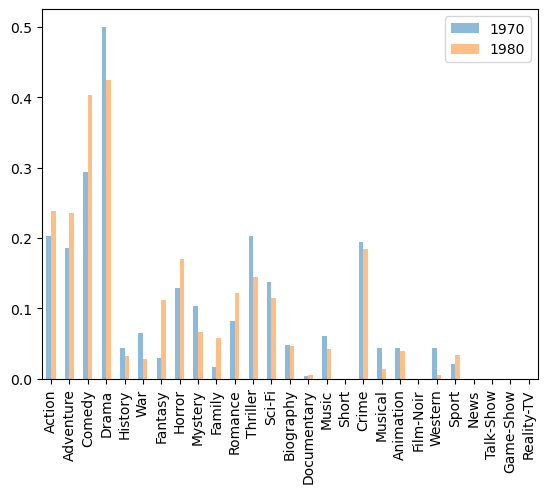

In [223]:
#testing
genre_proportion(testing_dec, "Sci-Fi", 2020)

#lawd
prop_decades.loc[:,1970:1980].plot.bar(alpha=0.5)

/var/folders/6f/gby23rkj45x00_41hqhn13n40000gn/T/ipykernel_56782/3061061540.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



TypeError: Image data of dtype object cannot be converted to float

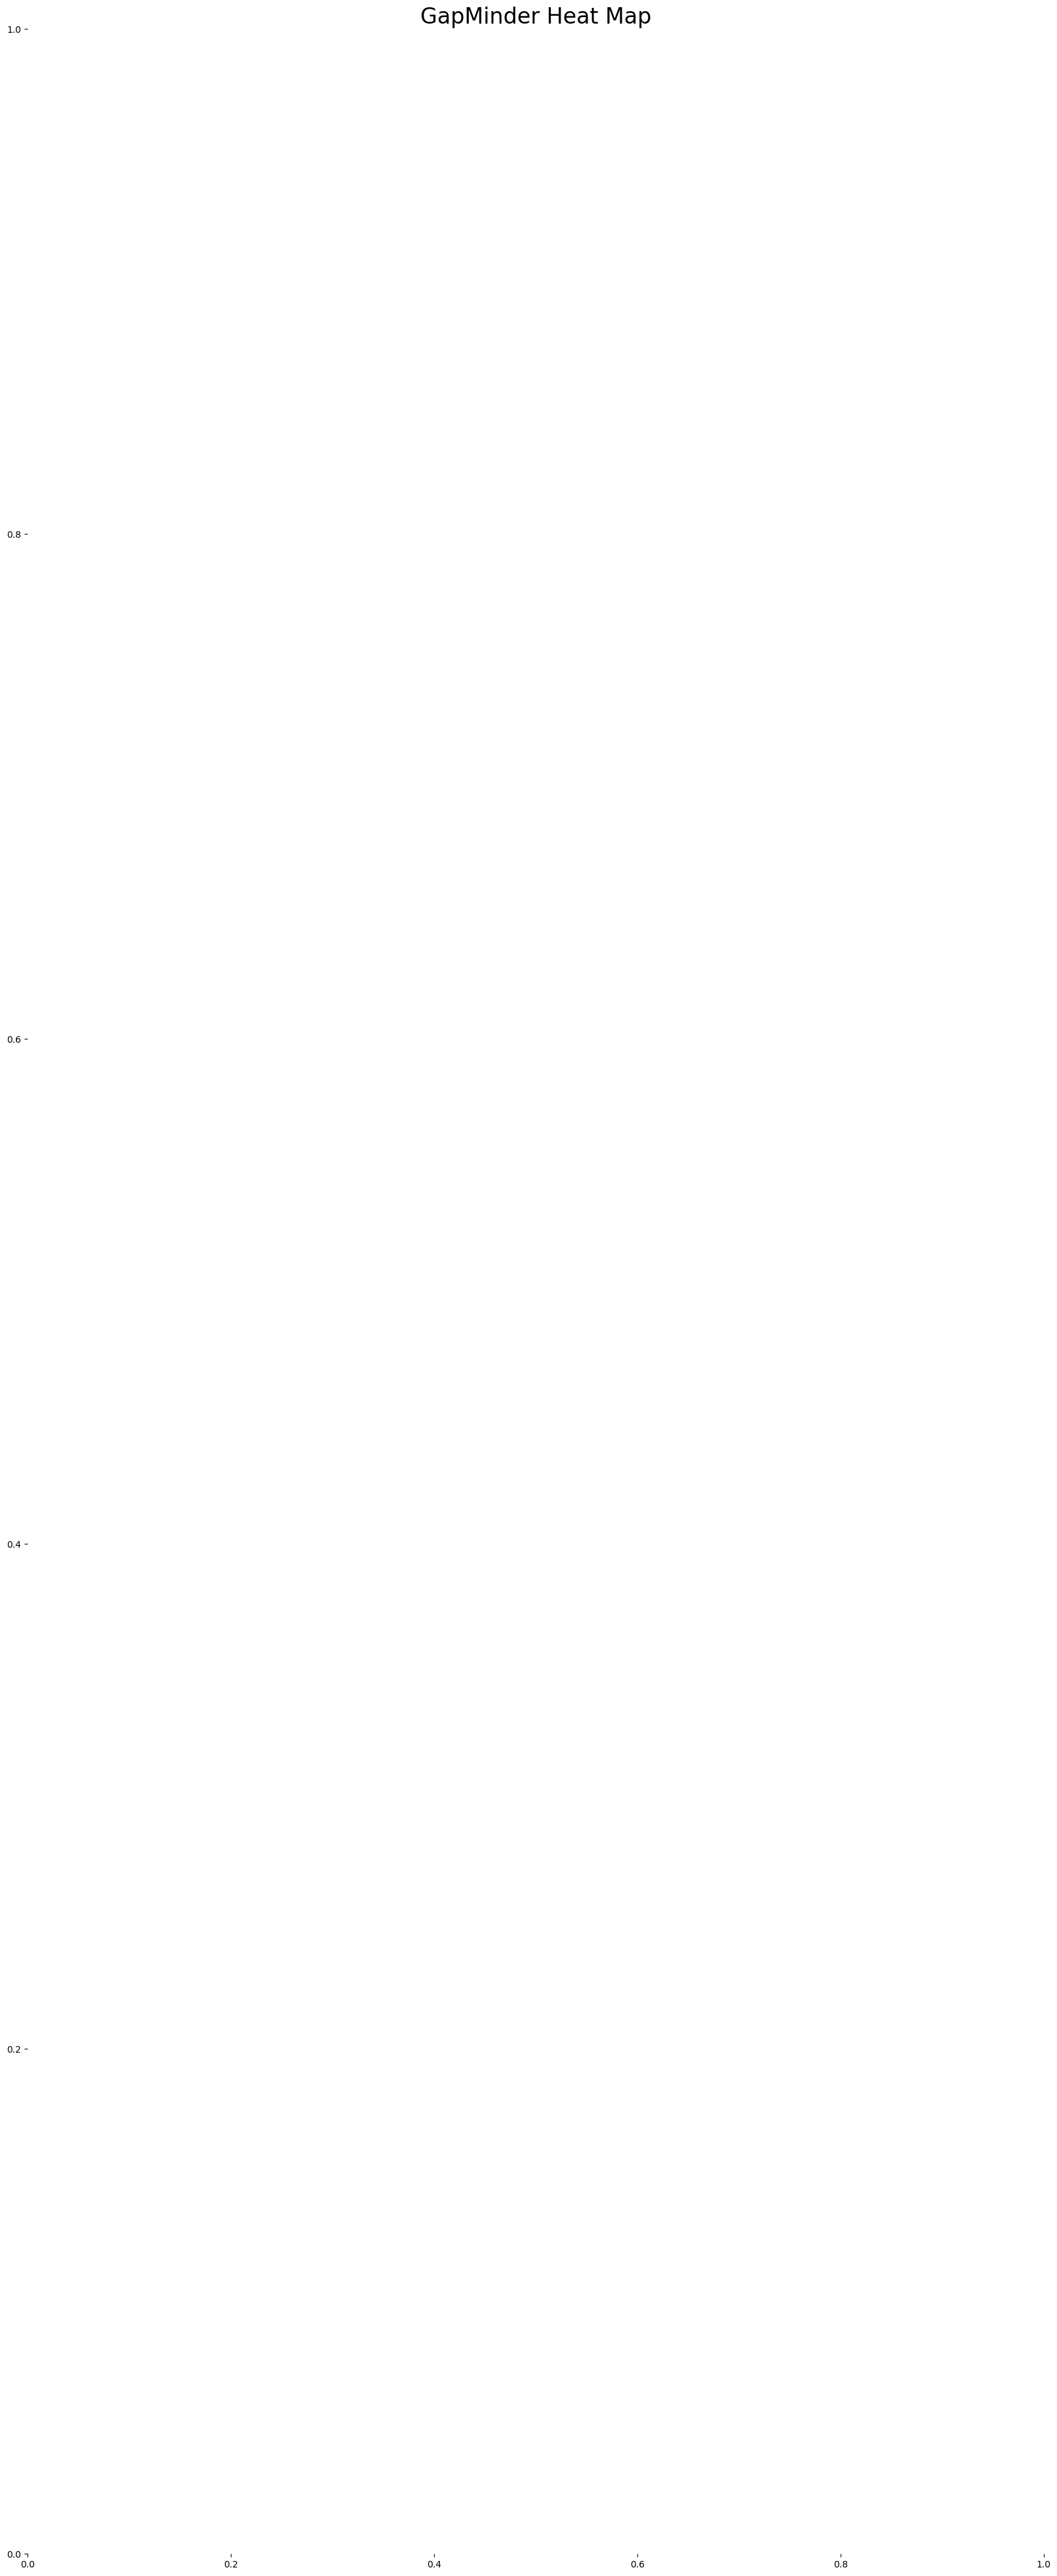

In [253]:
# Define the plot - feel free to modify however you want
plt.figure(figsize = [20, 50])

# Set the font size and the distance of the title from the plot
title = 'GapMinder Heat Map'
plt.title(title,fontsize=24)

ax = sns.heatmap(prop_decades, annot = True, fmt='f', linewidths = .5,
                 cmap = plt.cm.get_cmap('RdYlGn', 7), cbar_kws={
                     'label': 'Life Expectancy', 'shrink': 0.5})

# This sets a label, size 20 to your color bar
ax.figure.axes[-1].yaxis.label.set_size(20)
plt.show()

In [234]:
# plotting the features "drama" & "sci-fi" for a movie in the 1980s ??

def plotting_movies():
    "plot a test movie and training movies using two features"